In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model, Model
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense


In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class StockEnv:
    def __init__(self, data, initial_balance=10000):
        self.data = data
        self.initial_balance = initial_balance
        self.state_size = data.shape[1] + 3 # stock data + balance + net_worth + stock_owned
        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.current_step = 0
        self.stock_owned = 0
        return self._get_observation()

    def _get_observation(self):
        obs = np.hstack((self.data.iloc[self.current_step].values, [self.balance, self.net_worth, self.stock_owned]))
        return obs

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        # print(current_price)
        #print(self.net_worth)
        prev_net_worth = self.net_worth
        if action == 0: # Buy
            if current_price <= self.balance:
                self.stock_owned += 1
                self.balance -= current_price
                self.net_worth = self.balance + self.stock_owned * current_price
        elif action == 1: # Sell
            if self.stock_owned > 0:
                self.stock_owned -= 1
                self.balance += current_price
                self.net_worth = self.balance + self.stock_owned * current_price
        elif action == 2:
            self.net_worth = self.balance + self.stock_owned * current_price
        print(self.balance,current_price)

        # Go to the next day
        self.current_step += 1

        # Calculate reward
        reward = (self.net_worth - prev_net_worth) / prev_net_worth
        print(reward)

        # Check if done
        done = (self.current_step == 100 - 1)

        return (self._get_observation(), reward, done)

class ActorCritic:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95
        self.learning_rate = 0.001

        self.actor = self.build_actor()
        self.critic = self.build_critic()

    def build_actor(self):
        state_input = Input(shape=(self.state_size,))
        dense1 = Dense(32, activation='relu')(state_input)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(self.action_size, activation='softmax')(dense2)

        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def build_critic(self):
        state_input = Input(shape=(self.state_size,))
        dense1 = Dense(32, activation='relu')(state_input)
        dense2 = Dense(32, activation='relu')(dense1)
        output = Dense(1, activation='linear')(dense2)

        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def train(self, state, action, reward, next_state, done):
        target = np.zeros((1, 1))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.gamma * next_value - value
            target[0][0] = reward + self.gamma * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)

    def act(self, state):
        probabilities = self.actor.predict(state)[0]
        action = np.random.choice(self.action_size, p=probabilities)
        return action

def test_model(env, actor_critic, stock):
    state = env.reset()
    state = np.reshape(state, [1, env.state_size]).astype(np.float32)
    done = False
    total_reward = 0

    total_rewards = []
    while not done:
        action = actor_critic.act(state)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state, [1, env.state_size]).astype(np.float32)
        state = next_state
        total_reward += reward
        total_rewards.append(total_reward)
    current_price = env.data.iloc[100]['Close']
    profit = env.balance + (env.stock_owned*current_price) - env.initial_balance
    plt.plot(total_rewards)
    plt.title(f"{stock}\n Total Profit : {profit}")
    plt.xlabel('days')
    plt.ylabel('Total Rewards')
    plt.show()

    return total_reward





1/1 [==============================] - 0s 185ms/step
9999.997670663219 0.0023293367820855365
0.0
1/1 [==============================] - 0s 21ms/step
9999.996070137331 0.001600525887077174
-7.288108954526251e-08
1/1 [==============================] - 0s 25ms/step
9999.995384197666 0.0006859396658902145
-1.8291725742330466e-07
1/1 [==============================] - 0s 27ms/step
9999.994798290867 0.0005859067979478924
-3.000986820586398e-08
1/1 [==============================] - 0s 27ms/step
9999.994083770382 0.0007145204853023085
5.1445489740868626e-08
1/1 [==============================] - 0s 28ms/step
9999.993812252596 0.00027151778441487223
-2.2150140255460961e-07
1/1 [==============================] - 0s 27ms/step
9999.993812252596 0.0
-1.6291074485288994e-07
1/1 [==============================] - 0s 27ms/step
9999.993469282763 0.00034296983294510724
2.4007903151666537e-07
1/1 [==============================] - 0s 24ms/step
9999.992826214326 0.0006430684367720804
2.4007897406063687e-

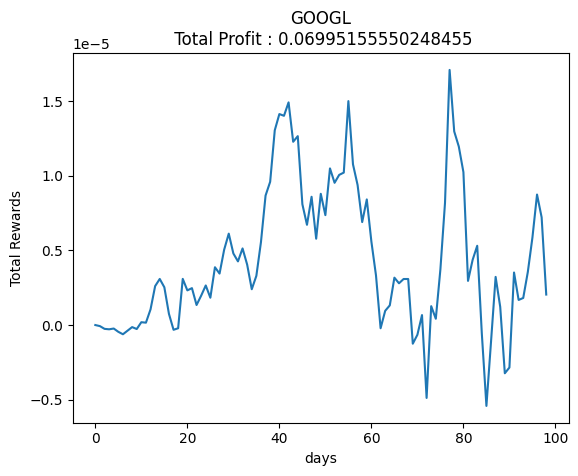

Total Reward: 2.0438771094582346e-06, Profit : 10000.069951555502
1/1 [==============================] - 0s 88ms/step
9999.99334509549 0.006654904509858561
0.0
1/1 [==============================] - 0s 23ms/step
9999.990621227598 0.0027238678924072363
-3.931036617359496e-07
1/1 [==============================] - 0s 23ms/step
9999.989150957997 0.0014702696010152755
-2.507197568471443e-07
1/1 [==============================] - 0s 26ms/step
9999.987309251866 0.001841706131798071
1.114310311832463e-07
1/1 [==============================] - 0s 26ms/step
9999.983857987434 0.003451264431856879
6.4382366260914e-07
1/1 [==============================] - 0s 23ms/step
9999.981551985638 0.002306001795276569
-5.726312544006101e-07
1/1 [==============================] - 0s 23ms/step
9999.981551985638 0.0
-1.383601715331433e-06
1/1 [==============================] - 0s 24ms/step
9999.980453152568 0.0010988330702324661
7.691845681611803e-07
1/1 [==============================] - 0s 24ms/step
9999.9792

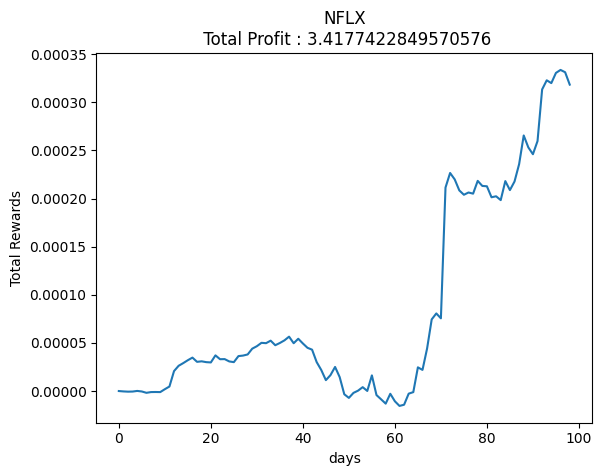

Total Reward: 0.0003184492144106386, Profit : 10003.417742284957
1/1 [==============================] - 0s 100ms/step
9999.970267218667 0.029732781332329705
0.0
1/1 [==============================] - 0s 35ms/step
9999.945364446115 0.024902772550495555
-4.830008783756057e-07
1/1 [==============================] - 0s 40ms/step
9999.920398946178 0.024965499937272623
1.2545483389174629e-08
1/1 [==============================] - 0s 48ms/step
9999.89311253293 0.02728641324802411
6.962743209102357e-07
1/1 [==============================] - 0s 43ms/step
9999.859365198845 0.03374733408606198
2.5843677515939787e-06
1/1 [==============================] - 0s 42ms/step
9999.825429682598 0.03393551624639318
9.409081565088282e-08
1/1 [==============================] - 0s 35ms/step
9999.79582235604 0.02960732655877557
-2.5969062702022945e-06
1/1 [==============================] - 0s 36ms/step
9999.764709572199 0.031112783841425184
1.0538197739707116e-06
1/1 [==============================] - 0s 44ms/s

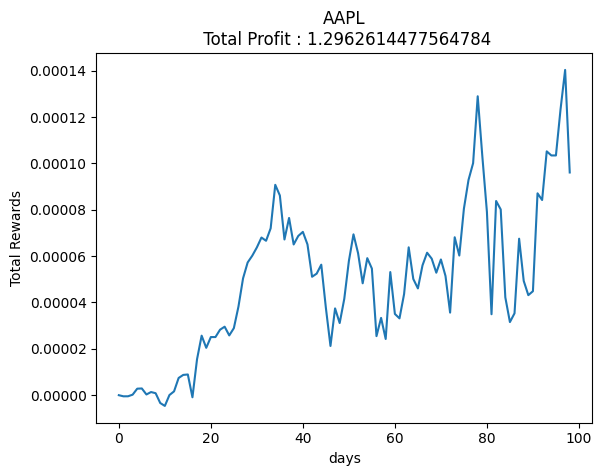

Total Reward: 9.609917425492295e-05, Profit : 10001.296261447756
1/1 [==============================] - 0s 98ms/step
9999.998003733757 0.0019962662427681563
0.0
1/1 [==============================] - 0s 34ms/step
9999.996598953809 0.0014047799486146297
-5.914862940699095e-08
1/1 [==============================] - 0s 49ms/step
9999.995841111995 0.0007578418143842081
-1.2938763449226264e-07
1/1 [==============================] - 0s 44ms/step
9999.994787527034 0.001053584961460973
8.87229609289308e-08
1/1 [==============================] - 0s 48ms/step
9999.993549102604 0.0012384244283839517
7.393579409304044e-08
1/1 [==============================] - 0s 38ms/step
9999.99262490527 0.0009241973346148895
-1.5711355105876947e-07
1/1 [==============================] - 0s 47ms/step
9999.992218258443 0.0004066468272305515
-3.105303611655115e-07
1/1 [==============================] - 0s 36ms/step
9999.991497384523 0.0007208739209996137
2.1995907423564917e-07
1/1 [==============================] 

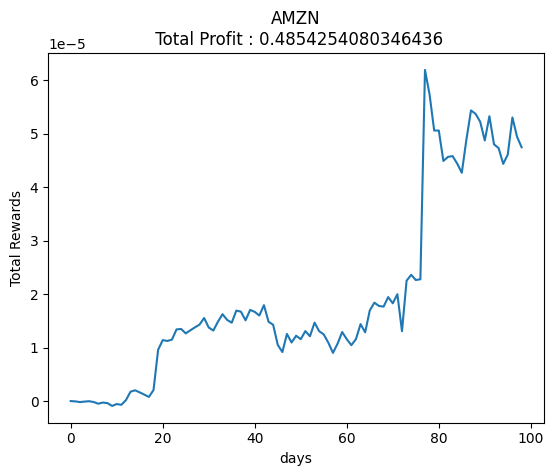

Total Reward: 4.7444564711651866e-05, Profit : 10000.485425408035
1/1 [==============================] - 0s 69ms/step
9999.985720312856 0.014279687145036218
0.0
1/1 [==============================] - 0s 24ms/step
9999.975529808848 0.010190504008048523
-4.0891831358749184e-07
1/1 [==============================] - 0s 23ms/step
9999.968714503619 0.006815305228312751
-6.750400320971005e-07
1/1 [==============================] - 0s 26ms/step
9999.96189919839 0.006815305228312751
0.0
1/1 [==============================] - 0s 29ms/step
9999.948528218609 0.013370979781261144
2.622272663655904e-06
1/1 [==============================] - 0s 29ms/step
9999.936552753708 0.01197546490117804
-6.977563665902401e-07
1/1 [==============================] - 0s 21ms/step
9999.927887579917 0.00866517379028331
-1.9861729971857373e-06
1/1 [==============================] - 0s 22ms/step
9999.920098659657 0.007788920260928839
-6.133781731707078e-07
1/1 [==============================] - 0s 21ms/step
9999.91286

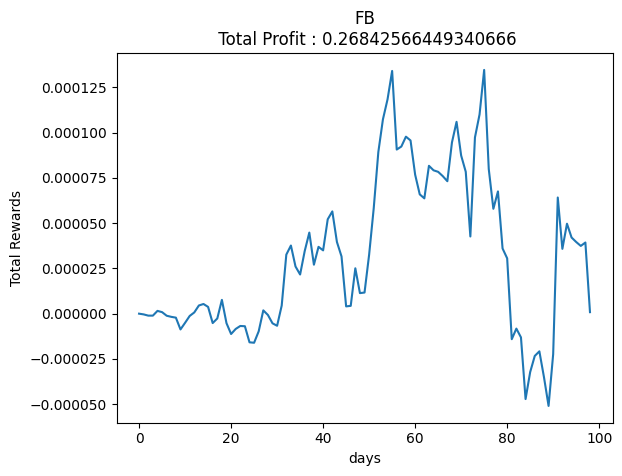

Total Reward: 8.356425239578751e-07, Profit : 10000.268425664493


In [6]:

df = pd.read_csv('/content/drive/MyDrive/SDP/new_dataset.csv')
groups = list(set(df['Symbol']))
df.head()
grouped_df = df.groupby('Symbol')
    #data = pd.read_csv('new_datset.csv')
for i in range(5):
    data = grouped_df.get_group(groups[i])
    data = data[['Open', 'High', 'Low', 'Close']]
    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    env = StockEnv(data)
    state_size = env.state_size
    action_size = 3 # Buy or Sell

    actor_critic = ActorCritic(state_size=state_size, action_size=action_size)
    actor_critic.actor = load_model('/content/drive/MyDrive/SDP/actor400.h5')
    actor_critic.critic = load_model('/content/drive/MyDrive/SDP/critic400.h5')
    total_reward = test_model(env=env, actor_critic=actor_critic, stock=groups[i])
    current_price = env.data.iloc[100]['Close']
    print(f'Total Reward: {total_reward}, Profit : {env.balance + env.stock_owned*current_price}')
